# Imports

In [43]:
import geopandas as gpd
import pandas as pd
import fiona
import os
import matplotlib.pyplot as plt
import folium
from zipfile import ZipFile
from folium.plugins import MarkerCluster, HeatMap, BeautifyIcon
from folium.map import LayerControl, Layer, FeatureGroup
import seaborn as sns
from shapely.geometry import Point, LineString, MultiPoint


# Challenge description

**Goals**<br>
Reducing the outdoor advertising visual impact in cities, minimising the reduction of the
audience of the outdoor ad sector. Improving the visual environment of cities and the
sustainability of the outdoor advertising activity.
A more careful organisation of outdoor advertising panels in cities will help achieve the
11th UN Sustainable Goal - Sustainable Cities and Communities, not only because it
increases the visual quality of streets and roads but also allows to increase the focus on
the message and the announcement that the panel intends to transmit.
<br>
**Outcome**<br>
Create a model that optimises the number and location of the outdoor advertising
positions in order to minimize the visual impact in urban environments. Consider also a
better dimensioning and integration of outdoor advertising positions in cities.

# Data

In [5]:
# IMPORT AND PAD COLUMN NAMES
geo = gpd.read_file('data/outdoor_inventory').rename(columns={'Max_Visibi':'Max_Visibility_Distance', 'Average_Da':'Average_Daily_Views'})


In [7]:
geo.head()

,PanelID,X,Y,Max_Visibility_Distance,Average_Daily_Views,geometry
0,26144,-8.473975,40.900768,69,31.0,POINT (-8.47397 40.90077)
1,11714,-9.315949,38.958125,69,31.0,POINT (-9.31595 38.95813)
2,26109,-8.510079,40.871821,69,32.0,POINT (-8.51008 40.87182)
3,32555,-8.479751,40.837695,69,32.0,POINT (-8.47975 40.83769)
4,5291,-8.429870,40.268692,69,32.0,POINT (-8.42987 40.26869)


In [8]:
geo.describe()

,PanelID,X,Y,Max_Visibility_Distance,Average_Daily_Views
count,30375.000000,30375.000000,30375.000000,30375.000000,30375.000000
mean,20152.920230,-8.846455,39.632174,77.181267,7302.318656
std,12684.266981,0.388097,1.293727,22.593576,6112.093208
min,3.000000,-9.475810,37.012431,61.000000,31.000000
25%,10662.500000,-9.162180,38.717190,69.000000,3221.000000
50%,19913.000000,-8.898694,38.788461,69.000000,5923.000000
75%,27761.500000,-8.585569,41.148252,69.000000,9621.000000
max,49326.000000,-7.129245,42.106631,180.000000,81532.000000


In [37]:
geo.Max_Visibility_Distance.idxmin()

621

In [41]:
m = folium.Map([39.632174, -8.846455])

# ALL ADS
marker_cluster = MarkerCluster(name = 'all_ads')

for c, row in geo.iterrows():
    tooltip = row.PanelID
    popup = f'Average_Daily_Views: \n{row.Average_Daily_Views}'
    folium.Marker([row.Y, row.X], tooltip=tooltip, popup=popup).add_to(marker_cluster)
    
marker_cluster.add_to(m)

# OUTLIERS
outs = FeatureGroup(name='Outliers', show=False)
# min vis dist
min_vis = geo.Max_Visibility_Distance.idxmin()
folium.Marker((geo.loc[min_vis, 'Y'], geo.loc[min_vis, 'X']), 
              tooltip=f'Minimum visibility {geo.loc[min_vis, "Max_Visibility_Distance"]}').add_to(outs)

# min views
min_view = geo.Average_Daily_Views.idxmax()
folium.Marker((geo.loc[min_view, 'Y'], geo.loc[min_view, 'X']), 
              tooltip=f'Minimum views {geo.loc[min_view, "Average_Daily_Views"]}').add_to(outs)
# max views
max_view = geo.Average_Daily_Views.idxmin()
folium.Marker((geo.loc[max_view, 'Y'], geo.loc[max_view, 'X']), 
              tooltip=f'Max views {geo.loc[max_view, "Max_Visibility_Distance"]}').add_to(outs)

outs.add_to(m)

LayerControl().add_to(m)

m
print('Activate layers to see outliers')

Activate layers to see outliers


<AxesSubplot:xlabel='Max_Visibility_Distance', ylabel='Count'>

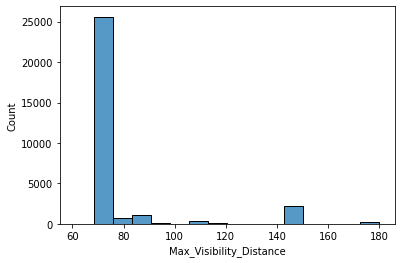

In [27]:
sns.histplot(geo.Max_Visibility_Distance)

<AxesSubplot:xlabel='Average_Daily_Views', ylabel='Count'>

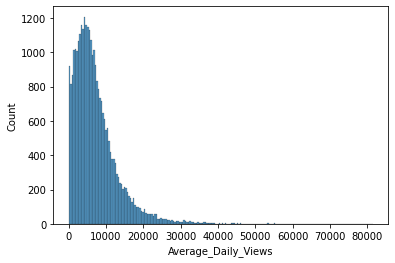

In [26]:
sns.histplot(geo.Average_Daily_Views)

In [32]:
geo.isna().sum()

PanelID                    0
X                          0
Y                          0
Max_Visibility_Distance    0
Average_Daily_Views        0
geometry                   0
dtype: int64

**Findings**:<br>

- 30k rows spread over all Portugal
- Data seems clean, no nan

# Suggestions

- Devide dataset:
    - Only highway ads
    - Only Lisbon data
    - Only ads with low visibility range (inside cities, close to pedestrian areas)

In [47]:
## Filtering only lisbon data at 38.72526068747401, -9.142352617846093
circle_lisbon = Point(-9.142352617846093, 38.72526068747401).buffer(1)
geo_lis = geo[geo.geometry.within(circle_lisbon)]
geo_lis.shape

(15821, 6)

**Lisbon Data**:
- represents half of all data

In [ ]:
m = folium.Map([38.7252, -9.142])

# ALL ADS
marker_cluster = MarkerCluster(name = 'Lis_ads')

for c, row in geo_lis.iterrows():
    tooltip = row.PanelID
    popup = f'Average_Daily_Views: \n{row.Average_Daily_Views}'
    folium.Marker([row.Y, row.X], tooltip=tooltip, popup=popup).add_to(marker_cluster)
    
marker_cluster.add_to(m)
m